## Studets details

Student1
* Name: Yariv Levy
* ID: 313178865
* Username: yarivlevy

Student2
* Name:
* ID:
* Username:

Student3
* Name:
* ID:
* Username:

### General tip

While debugging you might want to use:
```python
import importlib
importlib.reload(model)
```

to reload the model module without repeating unnecessary cells.

### Import relevant packages - you might need to pip install some 

In [1]:
import torch
import data_loader
from traineval import train, evaluate
import model as model

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"deviced used is {device}")

deviced used is cpu


In [2]:
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
seed = 42

## Loading the Data

The following line of code invokes data_loader and will automatically download and extract the dataset if needed.
It instantiates the following variables;
* tokens_vocab - the sentence words vocabulary
* y_vocab - the labels (senses) vocabulary
* datasets - a dictionary with train,dev, and test WSDDataset instances.

Use the optional sentence_count kwarg to limit the number of sentences loaded.

In [4]:
train_dataset, tokens_vocab, y_vocab = data_loader.load_train_dataset()
train_dataset

Samples: 204162 (no_sense: 0)
Sentences: 29740 (N=270)
Vocab:
	Tokens:39272
	Senses:25378

In [5]:
dev_dataset = data_loader.load_dev_dataset(tokens_vocab, y_vocab)
dev_dataset

Samples: 25619 (no_sense: 0)
Sentences: 3717 (N=134)
Vocab:
	Tokens:39272
	Senses:25378

## Part 1: Query-Based Attention

Implement the relevant parts in model.py module. You might to check out this blog post about [gather method](https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4)

Load the model.

In [6]:
dropout = 0.25
D = 300
lr = 8e-5
batch_size=100
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, train_dataset, dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.502; epoch [4] loss: 2.801: 100%|██████████| 2042/2042 [17:23<00:00,  1.96it/s]


Train the model - you shoud see the loss decreasing and validation acc increasing from epoch to epoch.

In [7]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.514, "The last validation accuracy should be at least 0.514. Please check your implementation before you continue"

Validation accuracy: 0.518, Training accuracy:0.604


Plot the loss and training/validation accuracy. You should be getting ~54% validation accuracy after 10 epochs.

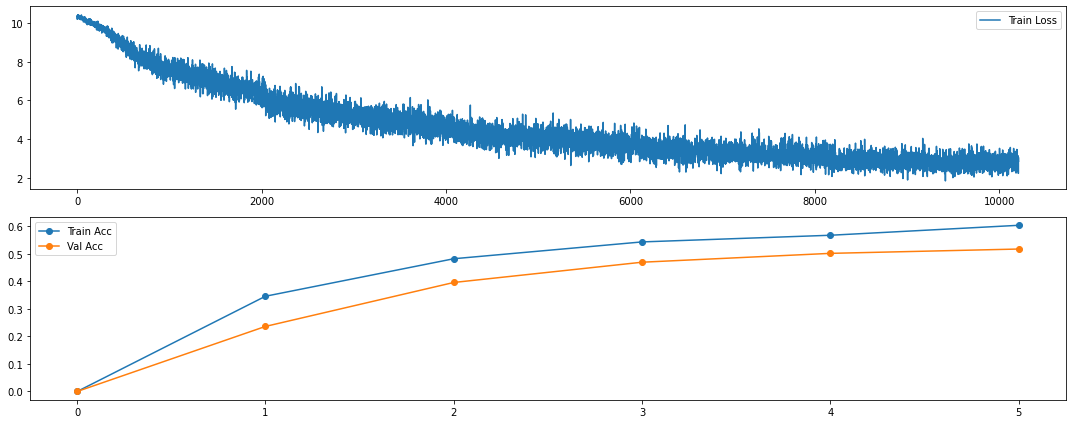

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

Use the attention vizualization to get a feel of what the model is attending to.

The query token is highlighted in green, and the model's attention with a pink-blue gradient.
In addition, the loss is given a red gradient.

In [11]:
from traineval import higlight_samples

higlight_samples(m, dev_dataset, sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,17,attracting,attract.v.00,attract.v.01,1.683e-04,8.688901,Only,a,token,start,was,made,in,attacking,the,tax,reappraisal,question,and,its,companion,issue,of,attracting,industry,to,the,state,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,58,fail,fail.v.02,fail.v.01,8.643e-02,2.448416,By,moving,the,term,``,Republic,'',to,lower,case,",",substituting,the,modern,phrase,``,move,ahead,'',for,the,<UNK>,``,keep,'',",",and,by,using,the,Postmaster,'s,name,on,every,envelope,(,in,caps,",",of,course,",",with,the,``,in,spite,'',as,faded,as,possible,),",",the,slogan,cannot,fail,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,30,probable,probable.a.01,probable.a.01,9.529e-01,0.048283,If,you,are,considering,a,part-time,farm,where,the,water,must,be,provided,by,a,well,",",find,out,if,there,is,a,good,well,on,the,farm,or,the,probable,cost,of,having,one,drilled,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,9,asked,ask.v.01,ask.v.01,8.692e-01,0.140212,``,Are,your,people,still,alive,'',?,he,asked,",",trying,to,touch,a,part,of,her,life,Alberto,had,n't,discussed,;,so,he,could,have,something,of,her,for,himself,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,18,<UNK>,<UNK>,reading.n.03,6.618e-06,11.910680,He,saw,the,figure,of,a,man,in,a,poncho,coming,up,the,company,street,",",with,an,<UNK>,of,wood,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Part 2: Padding

Implement the padding mask in the attention function in model.py.

Load the model and retrain.

In [7]:
dropout = 0.25
D = 300
lr = 8e-5
batch_size=100
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, train_dataset, dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.514; epoch [4] loss: 2.700: 100%|██████████| 2042/2042 [16:27<00:00,  2.07it/s]


In [8]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert round(val_acc[-1], 3) >= 0.527, "The last validation accuracy should be at least 0.527. Please check your implementation before you continue"

Validation accuracy: 0.529, Training accuracy:0.625


Plot the loss and training/validation accuracy.

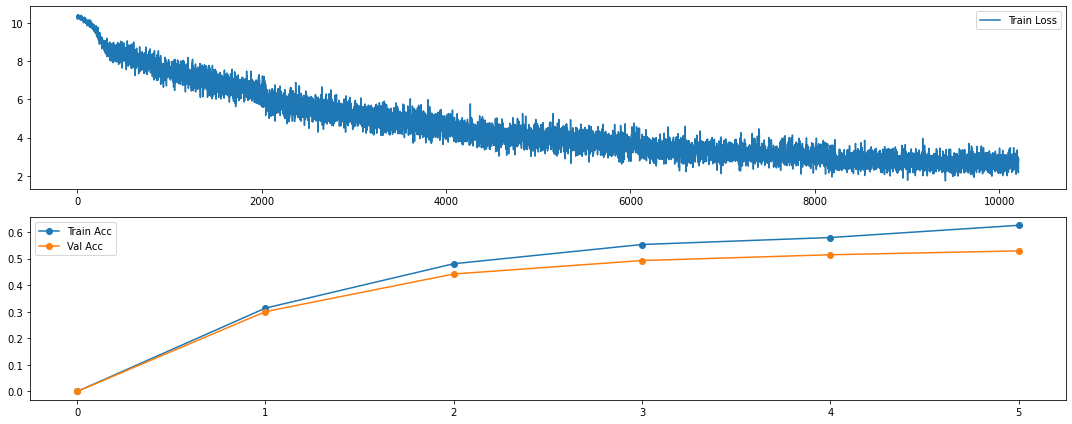

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [12]:
higlight_samples(m, dev_dataset, sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,11,are,be.v.02,be.v.01,1.827e-01,1.700018,Others,who,are,attracted,to,this,<UNK>,of,the,beat,generation,are,homosexuals,",",heroin,addicts,",",and,<UNK>,hoodlums,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,13,making,bring.v.03,make.v.01,1.933e-04,8.550900,Wall,panels,and,structural,timbers,are,standard,as,are,windows,and,doors,",",making,for,a,minimum,of,cutting,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,2,made,make.v.01,make.v.01,4.076e-01,0.897394,William,Lewis,made,the,rounds,of,all,who,lived,near,him,again,",",that,August,morning,after,a,bullet,landed,at,his,feet,",",and,once,more,he,accused,and,threatened,everyone,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,22,<UNK>,<UNK>,yellow.n.01,1.214e-05,11.311029,<UNK>,temperature,gradients,have,been,found,to,exist,in,liquid,helium,baths,contained,in,15,-,and,25,-,liter,metallic,storage,<UNK>,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,21,remarkable,remarkable.s.01,remarkable.s.01,9.900e-01,0.010077,In,May,",",1803,",",Ritter,",",in,another,flight,of,fancy,",",wrote,to,Oersted,a,letter,that,contained,a,remarkable,prophecy,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Examine additional examples, using the API and pandas as demonstrated below.

In [13]:
import pandas as pd
import numpy as np
from traineval import evaluate_verbose, highlight

pd.set_option('max_columns', 100)

eval_df, attention_df = evaluate_verbose(m, dev_dataset, iter_lim=100)

Visualization of 5 incorrectly classified examples.

In [14]:
idxs = np.where(eval_df['y_true'] != eval_df['y_pred'])
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,20,pretending,feign.v.01,dissemble.v.03,1.416e-01,1.954591,At,the,same,time,the,multiple,<UNK>,involved,-,the,fat,man,as,girl,and,as,baby,",",as,coquette,pretending,to,be,a,baby,-,touches,for,a,moment,<UNK>,upon,the,secret,sources,of,a,life,like,Jacoby,'s,",",upon,the,sinister,dreams,which,form,the,sources,of,any,human,life,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,39,solution,solution.n.02,solution.n.01,2.122e-04,8.457502,Instead,of,emotional,<UNK>,",",loaded,phrases,and,<UNK>,",",we,need,a,<UNK>,study,of,the,facts,",",a,better,understanding,of,the,opposite,viewpoint,and,a,more,serious,effort,to,extend,the,areas,of,agreement,until,a,solution,is,reached,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,2,<UNK>,<UNK>,similar.a.01,1.404e-06,13.407405,Others,carried,<UNK>,from,``,the,Forks,'',to,St.,Paul,and,goods,from,St.,Paul,to,Red,River,",",as,in,the,summer,of,1847,when,one,trader,",",Wells,",",transported,twenty,barrels,of,whisky,to,the,British,settlement,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,1,California,location.n.01,california.n.01,1.090e-05,11.417330,Southern,California,gasped,and,blinked,under,an,autumn,hot,spell,",",drier,",",more,enervating,",",more,laden,with,man,'s,contrived,impurities,than,the,worst,days,of,the,summer,past,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,2,return,tax_return.n.01,return.v.01,4.008e-01,0.914400,Send,your,return,to,the,Director,of,Internal,Revenue,for,the,district,in,which,you,have,your,legal,residence,or,principal,place,of,business,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Visualization of examples with the query word "left".

In [15]:
idxs = np.where(eval_df['query_token'] == 'left')
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
2900,2900,24,left,left_ventricle.n.01,leave.v.01,2.946e-03,5.827126,It,is,also,possible,to,utilize,a,pressure,transducer,",",mounted,at,the,end,of,a,<UNK>,which,is,inserted,into,the,heart,'s,left,ventricle,",",to,indicate,the,blood,pressure,in,the,heart,itself,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3675,3675,1,left,left_fielder.n.01,leave.v.01,7.043e-05,9.559418,The,left,fielder,threw,and,it,was,a,good,one,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4863,4863,13,left,leave.v.01,leave.v.01,4.411e-01,0.818449,If,we,manage,to,keep,track,of,a,Bombus,queen,after,she,has,left,her,feeding,place,",",we,may,discover,the,snug,little,<UNK>,which,she,has,fixed,up,for,herself,when,she,woke,up,from,her,winter,sleep,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5279,5279,1,left,leave.v.02,leave.v.01,9.796e-02,2.323165,Chandler,left,Carroll,at,the,bottom,of,the,hill,to,direct,any,reinforcements,he,could,find,to,the,fight,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5363,5363,8,left,leave.v.01,leave.v.01,2.920e-01,1.230957,They,had,been,seen,as,soon,as,they,left,the,ranch,",",picked,out,of,the,darkness,by,the,weary,though,watchful,eyes,of,two,men,posted,a,few,hundred,yards,away,in,the,<UNK>,shelter,of,the,trees,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6863,6863,27,left,leave.v.01,leave.v.01,3.528e-01,1.041953,The,president,of,the,Kansas,City,local,of,the,International,Association,of,Fire,<UNK>,was,<UNK>,injured,today,when,a,bomb,tore,his,car,apart,as,he,left,home,for,work,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9495,9495,1,left,leave.v.01,leave.v.01,4.645e-01,0.766715,Beckworth,left,the,tent,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9554,9554,17,left,left.a.01,leave.v.01,1.297e-01,2.042780,Start,with,the,class,standing,in,a,circle,",",with,weight,on,the,right,foot,and,the,left,extended,a,little,way,into,the,circle,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9565,9565,14,left,leave.v.01,leave.v.01,3.246e-01,1.125271,In,a,sense,",",he,is,offering,Bonn,what,its,famous,son,(,who,left,as,a,youth,),never,did,-,the,sound,of,the,composer,'s,mature,style,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9848,9848,19,left,leave.v.02,leave.v.01,9.905e-02,2.312167,The,news,of,battle,on,Breed,'s,Hill,had,already,seeped,through,",",and,New,York,itself,was,now,left,in,the,hands,of,the,local,<UNK>,Congress,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Part 3: Self-Attention

The method below converts the query-based instances in WSDDataset to sentence-level instances in WSDSentencesDataset for self-attention.

Notice how the number of samples now equals number of sentences.

In [6]:
sa_train_dataset = data_loader.WSDSentencesDataset.from_word_dataset(train_dataset)
sa_train_dataset

Samples: 29740
Sentences: 29740 (N=270)
Vocab:
	Tokens:39272
	Senses:25378

In [7]:
sa_dev_dataset = data_loader.WSDSentencesDataset.from_word_dataset(dev_dataset)
sa_dev_dataset

Samples: 3717
Sentences: 3717 (N=134)
Vocab:
	Tokens:39272
	Senses:25378

Implement self-attention in the model.

Load the model and retrain.

In [8]:
lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.542; epoch [4] loss: 1.732: 100%|██████████| 1487/1487 [1:49:57<00:00,  4.44s/it]


Plot the loss and training/validation accuracy.

In [9]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert val_acc[-1] >= 0.543, "The last validation accuracy should be at least 0.543. Please check your implementation before you continue"

Validation accuracy: 0.546, Training accuracy:0.669


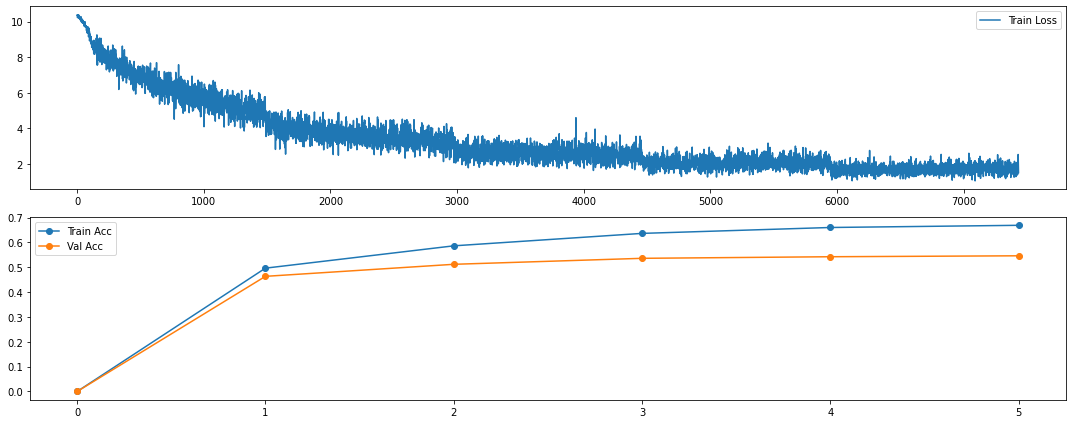

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

## Part 4: Positional embeddings


We do not provide "you code here" comments for this part as you should be familiar with the code by now

In [8]:
import positional_encoding

lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True,
    pos_enc=positional_encoding.PositionalEncoding
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

val: 0.540; epoch [4] loss: 1.744: 100%|██████████| 1487/1487 [1:34:28<00:00,  3.81s/it]


In [13]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert val_acc[-1] >= 0.538, "The last validation accuracy should be at least 0.543. Please check your implementation before you continue"

Validation accuracy: 0.539, Training accuracy:0.668


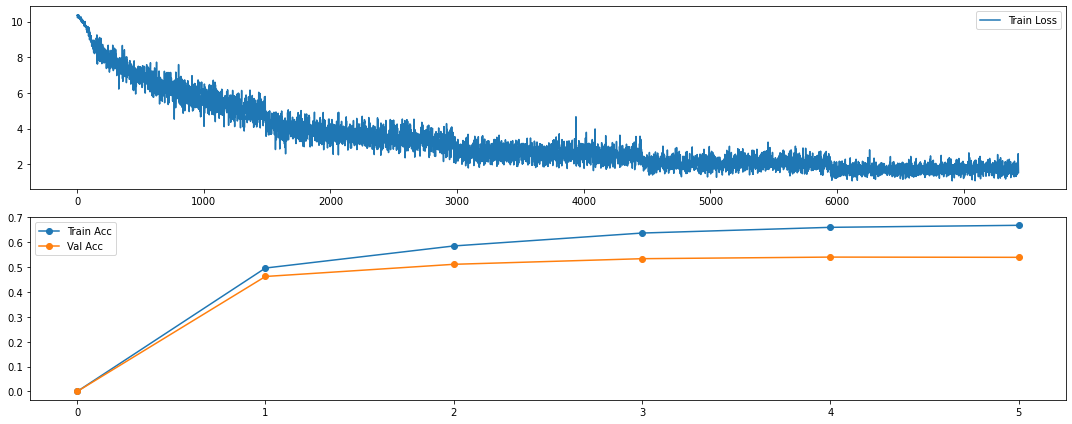

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()

In [19]:
from traineval import higlight_samples

# 5 Random samples
higlight_samples(m, dev_dataset, sample_size=5)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,17,problems,problem.n.01,problem.n.01,7.361e-01,0.306408,Production,specialists,are,available,in,SBA,regional,offices,to,help,individual,small,business,concerns,with,technical,production,problems,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,11,at,simultaneously.r.01,at_all.r.01,6.021e-02,2.809968,You,could,n't,on,the,one,hand,decry,the,arts,and,at,the,same,time,practice,them,",",could,you,?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,11,grown,turn.v.07,grow.v.02,2.065e-01,1.577635,As,an,obvious,consequence,",",obstacles,to,genuine,interfaith,communication,have,grown,more,formidable,in,one,important,area,:,relations,between,Christians,and,non-Christians,in,these,lands,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,14,<UNK>,NE,prosecutor.n.01,2.109e-06,13.022854,By,odd,coincidence,",",on,the,evening,of,her,return,Shelley,chose,to,read,<UNK>,",",which,was,the,latest,of,the,titled,poet,'s,successes,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,4,work,work.n.01,work.n.02,1.044e-01,2.259430,Some,persons,consider,the,work,on,a,farm,recreational,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [18]:
import pandas as pd
import numpy as np
from traineval import evaluate_verbose, highlight

pd.set_option('max_columns', 100)

eval_df, attention_df = evaluate_verbose(m, dev_dataset, iter_lim=100)

In [20]:
# 5 incorrect samples
idxs = np.where(eval_df['y_true'] != eval_df['y_pred'])
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
1,1,11,chemical,chemical.n.01,chemical.a.01,2.098e-01,1.561438,He,was,stirred,by,the,announcement,of,Volta,'s,discovery,of,chemical,electricity,and,he,immediately,applied,the,voltaic,pile,to,experiments,with,acids,and,alkalis,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,4,16,Slaughter,person.n.01,stiffen.v.01,5.194e-03,5.260292,``,<UNK>,does,n't,know,how,to,merely,go,through,the,motions,'',",",remarked,<UNK>,Slaughter,",",another,all-out,guy,",",who,played,rightfield,that,day,and,popped,one,over,the,clubhouse,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,5,6,backed,back_up.v.02,back.v.04,1.329e-01,2.017954,He,shouldered,the,blanket,again,",",backed,off,",",and,tossed,the,lantern,with,its,open,wick,beneath,the,wagon,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,7,15,longer,long.a.02,no_longer.r.01,5.656e-02,2.872432,If,",",in,a,certain,part,of,the,range,",",it,starts,life,1,foot,longer,than,do,any,of,the,other,(,relatively,large,),giants,",",and,reaches,maturity,at,",",let,us,guess,",",18,inches,longer,than,the,others,",",a,<UNK>,of,the,maturity,length,would,result,in,a,maximum,of,(,nearly,),40,feet,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,8,9,together,bond.v.04,together.r.02,2.691e-02,3.615326,The,members,of,the,``,family,'',are,drawn,together,by,a,common,love,for,Christ,and,a,sincere,devotion,to,His,Kingdom,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [21]:
# 5 correct samples
idxs = np.where(eval_df['y_true'] == eval_df['y_pred'])
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,4,sue,action.v.01,action.v.01,9.991e-01,0.000904,Berger,'s,decision,to,sue,for,the,full,amount,of,the,performance,bond,was,questioned,by,Wagner,in,the,morning,press,conference,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,11,more,more.r.01,more.r.01,5.354e-01,0.624819,What,is,new,in,the,context,is,likely,to,be,made,more,prominent,than,what,is,not,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,3,54,identification,designation.n.03,designation.n.03,4.260e-01,0.853324,Very,likely,it,will,also,include,a,recognition,that,the,work,we,are,reading,reflects,or,``,belongs,to,'',some,way,of,thought,labelled,as,a,``,school,'',or,an,``,-,ism,'',",",i.,e.,a,complex,or,``,<UNK>,'',of,ideas,occurring,together,with,sufficient,prominence,to,warrant,identification,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,6,25,averages,average.n.01,average.n.01,2.809e-01,1.269673,Certainly,there,would,be,less,anxiety,",",fewer,accidents,(,it,is,the,clumsy,child,who,<UNK>,the,worst,injuries,),",",and,higher,scholastic,averages,",",since,alert,children,work,better,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,10,21,musicianship,musicianship.n.01,musicianship.n.01,2.887e-01,1.242325,Thereafter,the,audience,waxed,applause,happy,",",but,discriminating,<UNK>,reserved,judgment,as,her,singing,showed,signs,of,strain,",",her,musicianship,some,<UNK>,procedure,and,her,acting,uncomfortable,stylization,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [22]:
# High probability samples
idxs = np.where(eval_df['y_pred_prob'] > 0.9)
idxs = list(idxs[0][:5])
highlight(eval_df, attention_df, idxs)

,index,query,query_token,y_true,y_pred,y_pred_prob,y_pred_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133
0,0,4,sue,action.v.01,action.v.01,9.991e-01,0.000904,Berger,'s,decision,to,sue,for,the,full,amount,of,the,performance,bond,was,questioned,by,Wagner,in,the,morning,press,conference,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,13,12,consisting,consist_of.v.00,consist_of.v.00,9.994e-01,0.000579,George,Shearing,took,over,with,his,well,disciplined,group,",",a,sextet,consisting,of,<UNK>,",",guitar,",",bass,",",drums,",",Shearing,'s,piano,and,a,<UNK>,<UNK>,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
23,23,55,ballad,ballad.n.01,ballad.n.01,9.837e-01,0.016422,He,was,also,at,the,same,time,gaining,practical,experience,as,a,safe,<UNK>,and,<UNK>,",",and,learning,how,to,shoot,to,kill,from,a,<UNK>,convicted,murderer,named,Gene,<UNK>,",",later,committed,to,Chester,<UNK>,as,a,<UNK>,maniac,",",but,whose,eyes,<UNK>,with,tears,when,the,young,<UNK>,sang,a,ballad,about,an,Irish,mother,in,his,clear,and,syrupy,tenor,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27,27,25,usually,normally.r.01,normally.r.01,1.000e+00,0.000015,Where,schools,",",fire,and,police,protection,",",and,similar,municipal,services,are,of,equal,quality,in,city,and,country,",",real,estate,taxes,are,usually,about,the,same,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,29,16,possess,possess.v.01,possess.v.01,9.310e-01,0.071535,But,actually,these,accounts,reveal,the,supernatural,powers,that,the,masters,were,in,fact,supposed,to,possess,",",as,well,as,the,extreme,degree,of,popular,credulity,:,``,Hwang,Pah,(,O,<UNK>,),",",one,day,going,up,Mount,Tien,<UNK>,",",which,was,believed,to,have,been,inhabited,by,<UNK>,with,supernatural,powers,",",met,with,a,monk,whose,eyes,emitted,strange,light,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Part 5: Causal Attention

We do not provide "you code here" comments for this part as you should be familiar with the code by now

In [8]:
# TODO: your experiments here
import positional_encoding

lr=2e-4
dropout = 0.2
D=300
batch_size=20
num_epochs=5
set_seed(seed)

m = model.WSDModel(
    tokens_vocab.size(), 
    y_vocab.size(), 
    D=D, 
    dropout_prob=dropout,
    use_padding=True,
    pos_enc=positional_encoding.PositionalEncoding,
    causal=True
).to(device)

optimizer = torch.optim.Adam(m.parameters(), lr=lr)

losses, train_acc, val_acc = train(
    m, optimizer, sa_train_dataset, sa_dev_dataset, num_epochs=num_epochs, batch_size=batch_size)

/Users/yalevy/Dev/yariv/NLP_HW/hw1/model.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = A + torch.tensor(torch.triu(torch.full(A.shape, -1000), diagonal=0), device=A.device)
val: 0.543; epoch [4] loss: 1.716: 100%|██████████| 1487/1487 [1:34:19<00:00,  3.81s/it]


In [11]:
print(f"Validation accuracy: {val_acc[-1]:.3f}, Training accuracy:{train_acc[-1]:.3f}")
assert val_acc[-1] >= 0.538, "The last validation accuracy should be at least 0.543. Please check your implementation before you continue"

Validation accuracy: 0.542, Training accuracy:0.682


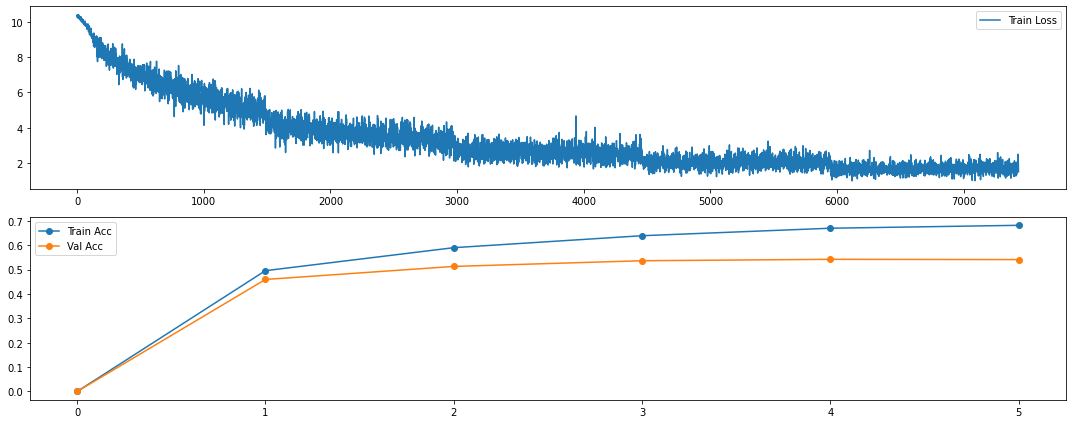

In [12]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6))

axs[0].plot(losses, '-', label='Train Loss');
axs[0].legend()
axs[1].plot(train_acc, '-o', label='Train Acc');
axs[1].plot(val_acc, '-o', label='Val Acc');
axs[1].legend()

plt.tight_layout()